In [9]:
from matplotlib import pyplot as plt
from scipy.stats import entropy
import numpy as np
import torch
import sys
import glob
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.ipc_collect()
#device = "cpu"

In [10]:
def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
class Metrics2():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==0).sum()


        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[targets==1],bins=50,normed=True,range=[50,300])
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=50,normed=True,range=[50,300])
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2),base=2)+entropy(hist2,0.5*(hist1+hist2),base=2))#*(bins[1]-bins[0])
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = bins[:-1]
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i]<cut).sum()/(digitized==i).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
            
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)

In [11]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

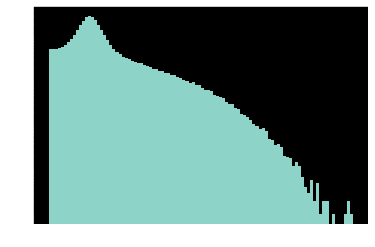

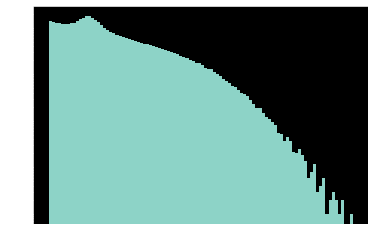

device: cuda:0


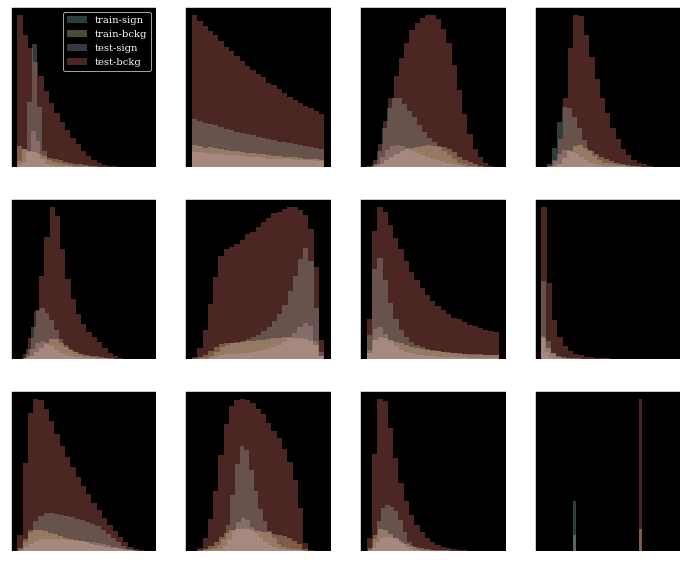

In [12]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]




plt.hist(train[::,0],bins=100,log=True)
plt.show()
plt.hist(val[::,0],bins=100,log=True)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float().to(device)

print('device:', device)

fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
fig.savefig("./logs/new/2048/data.pdf")
test_mass = files["test"].astype('float32')[:,0]*250+50

In [13]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 2048*4,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

Text(0.5, 1.0, '16384 batch size')

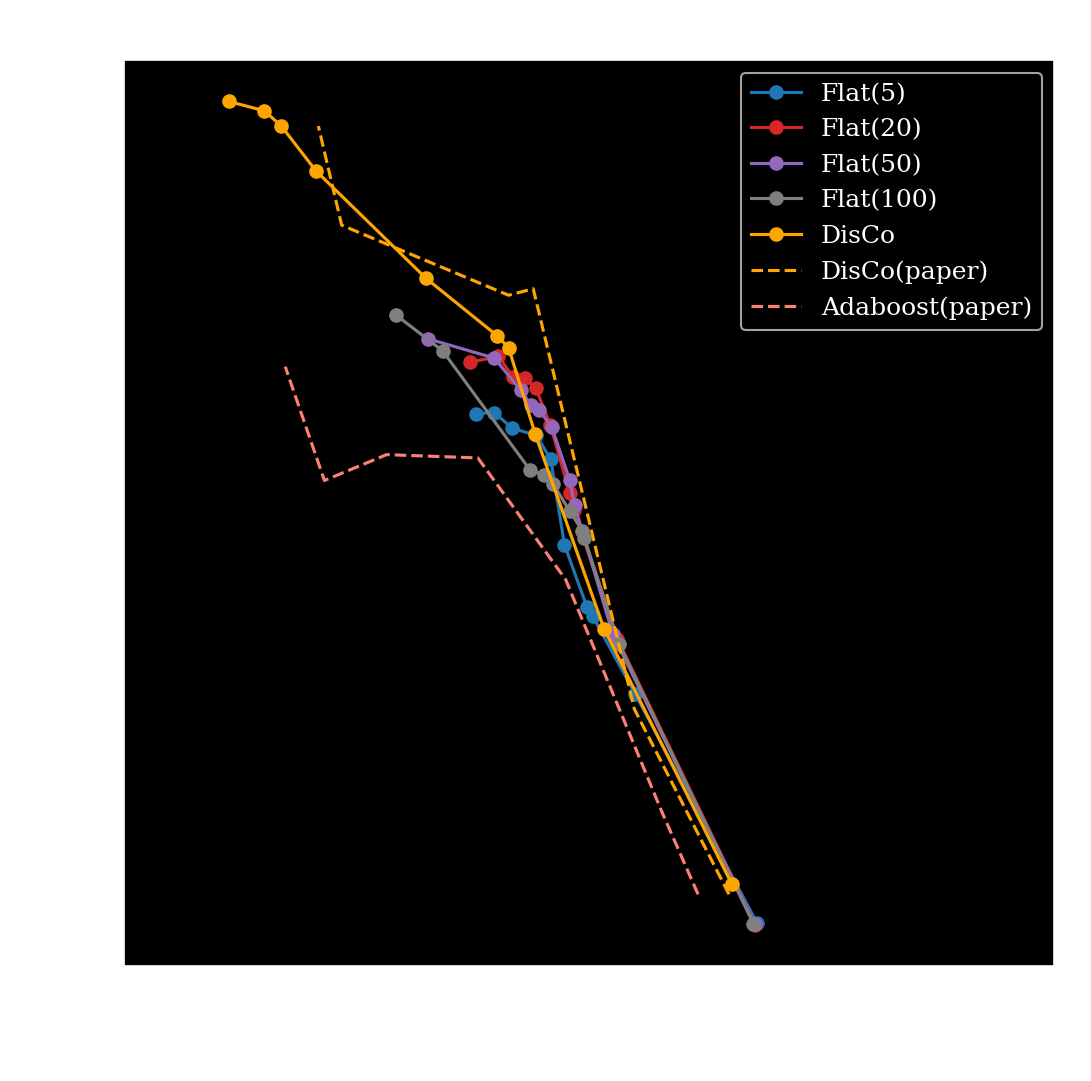

In [21]:
#mod
model_L.to("cpu")
Y = X.to('cpu')
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
c = ["tab:blue","tab:red","tab:purple","tab:gray"]
for i,b in enumerate([5,20,50,100]):
    jsdr50 = list()
    files = glob.glob(f"./logs/new/16384/Flat*b{b}).pt")
    for f in files:
        model_L.load_state_dict(torch.load(f))
        out=metric_calc(model=model_L,X=Y,y=test_labels,x_biased=test[:,0])
        jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=int))
    jsd,r50 = zip(*np.array(jsdr50)[sort])
    plt.errorbar(r50,jsd,fmt='-o',label=f'Flat({b})',c=c[i])
jsdr50 = list()
files = glob.glob("./logs/new/16384/DisCo*.pt")
for f in files:
    model_L.load_state_dict(torch.load(f))
    out=metric_calc(model=model_L,X=Y,y=test_labels,x_biased=test[:,0])
    jsdr50.append(out)
    sort = np.argsort(np.array([f.split('f')[1].split('b')[0] for f in files],dtype=int))
jsd,r50 = zip(*np.array(jsdr50)[sort])
plt.errorbar(r50,jsd,fmt='-o',label='DisCo',c='orange')

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    

plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("16384 batch size",fontsize=20)


# Flat str

strength 1
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (253.9s)
 Train: loss:0.2026, acc:80% || Val: loss: 0.0530, acc:82%, R50: 25.6291, 1/JSD: 3.0354


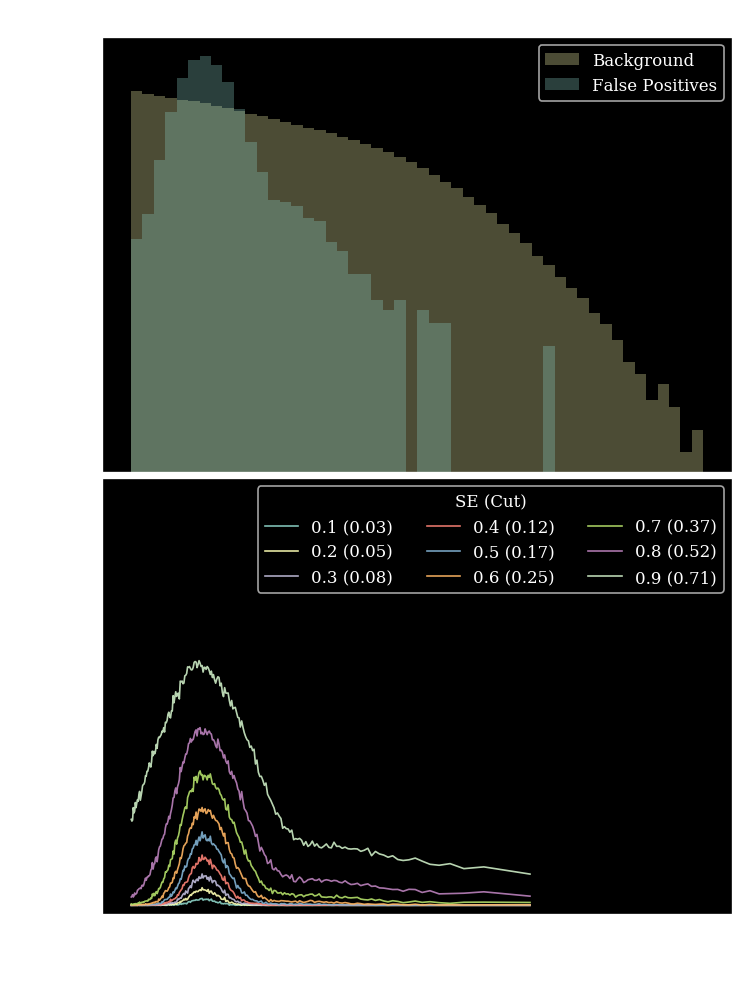

strength 1
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (279.0s)
 Train: loss:0.2014, acc:80% || Val: loss: 0.0529, acc:82%, R50: 26.0458, 1/JSD: 3.0205


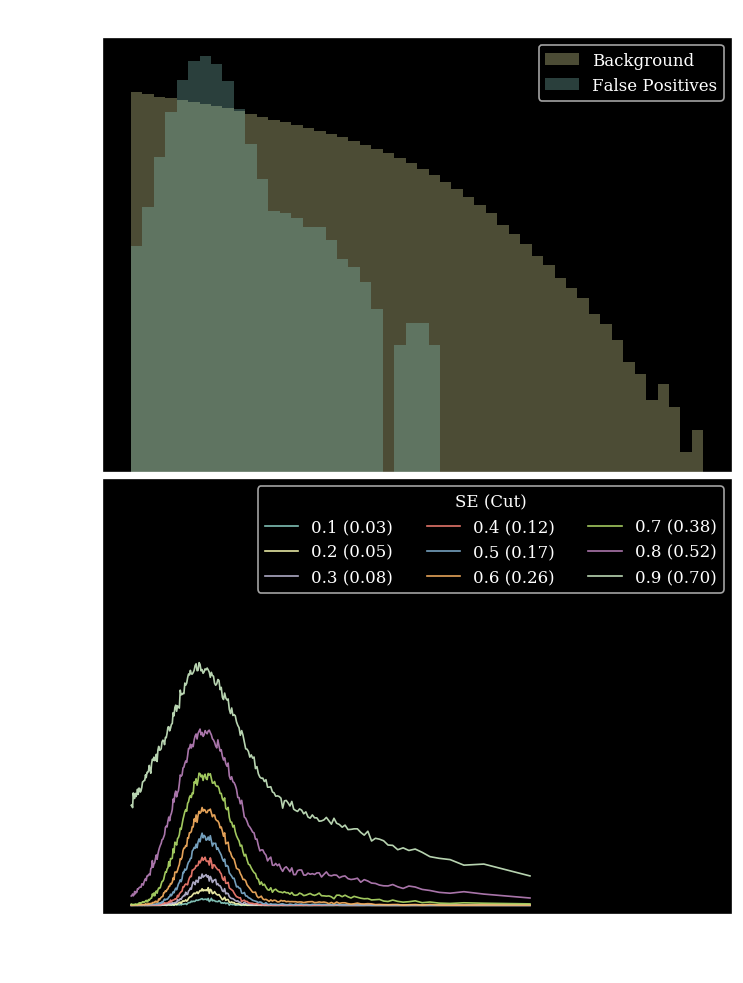

strength 1
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625


In [ ]:
jsdR50flatstr = []
for i,frac in enumerate([1,20,45,75,100,125,200,500,1000,1500]):
    for bins in [5,20,50,100]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=False,order=1)
        log=Logger(f"./logs/new/8192(1)/Flat(f{frac}b{bins}).txt")
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        torch.save(model_L.state_dict(),f"./logs/new/8192(1)/Flat(f{frac}b{bins}).pt")
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}, bins:{bins}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/8192(1)/Flat(f{frac}b{bins}).png")
        jsdR50flatstr.append(out)

strength 1
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (280.7s)
 Train: loss:0.2062, acc:80% || Val: loss: 0.0534, acc:83%, R50: 26.6344, 1/JSD: 3.0120


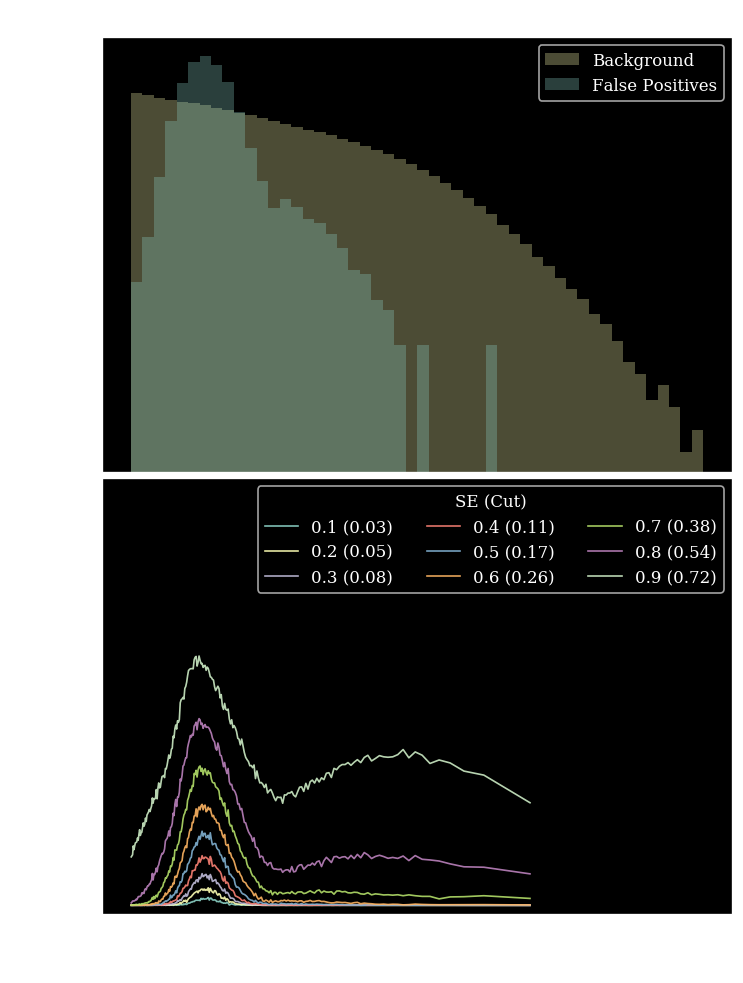

strength 1
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (263.4s)
 Train: loss:0.2089, acc:79% || Val: loss: 0.0537, acc:83%, R50: 26.4954, 1/JSD: 3.1458


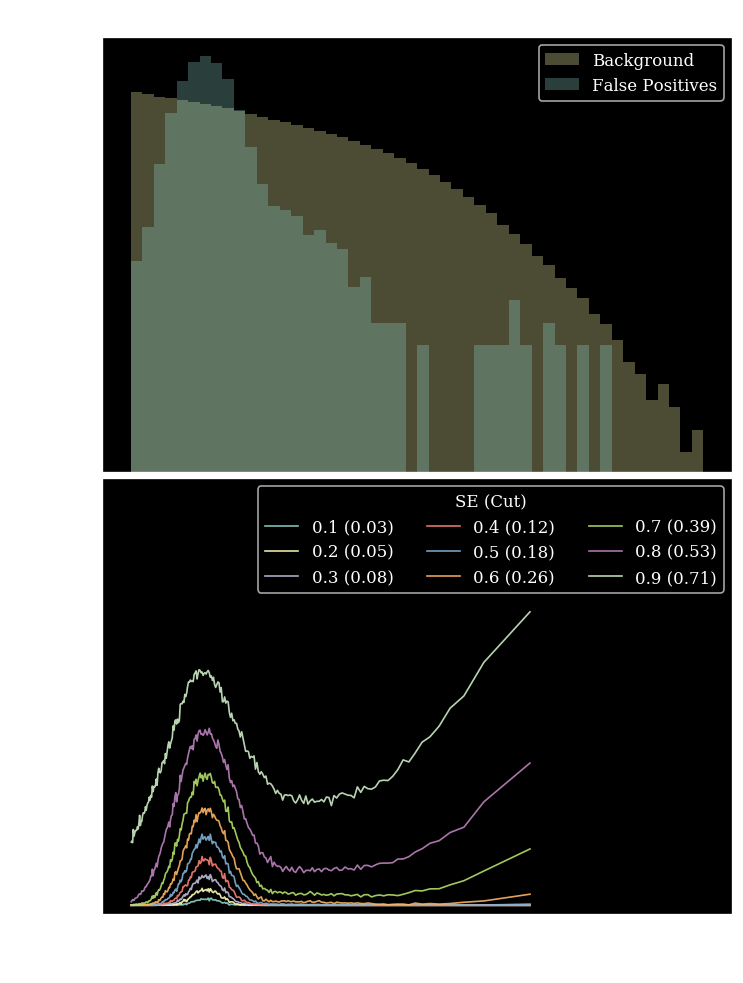

strength 1
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (278.9s)
 Train: loss:0.2096, acc:79% || Val: loss: 0.0537, acc:83%, R50: 26.4805, 1/JSD: 2.9966


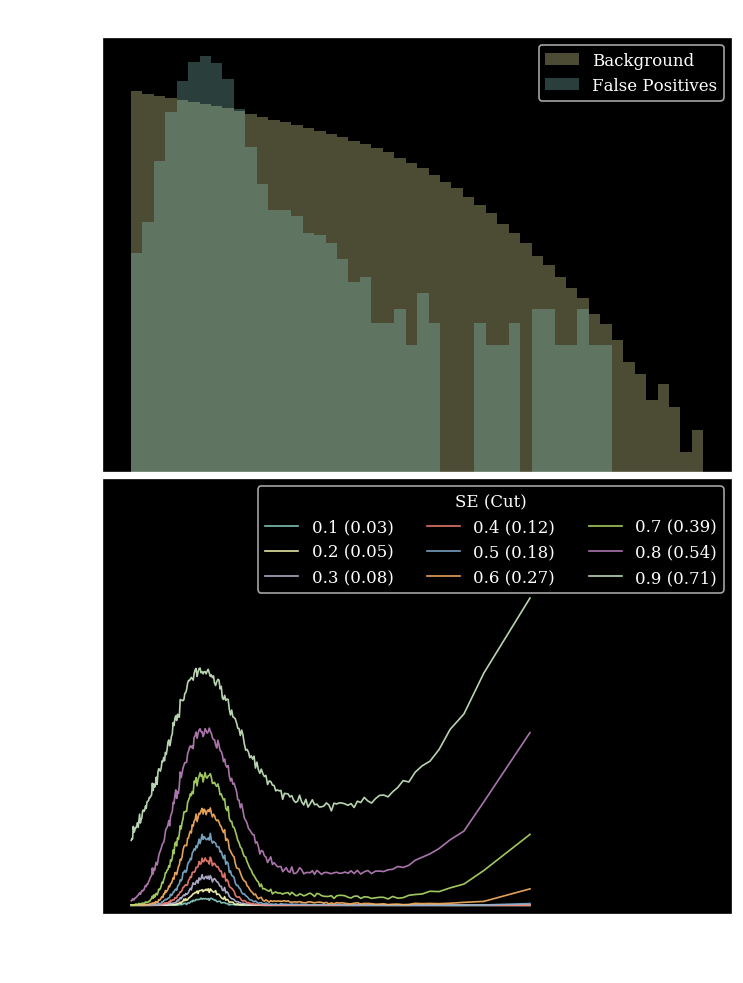

strength 1
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (294.1s)
 Train: loss:0.2126, acc:79% || Val: loss: 0.0537, acc:83%, R50: 26.2676, 1/JSD: 3.0047


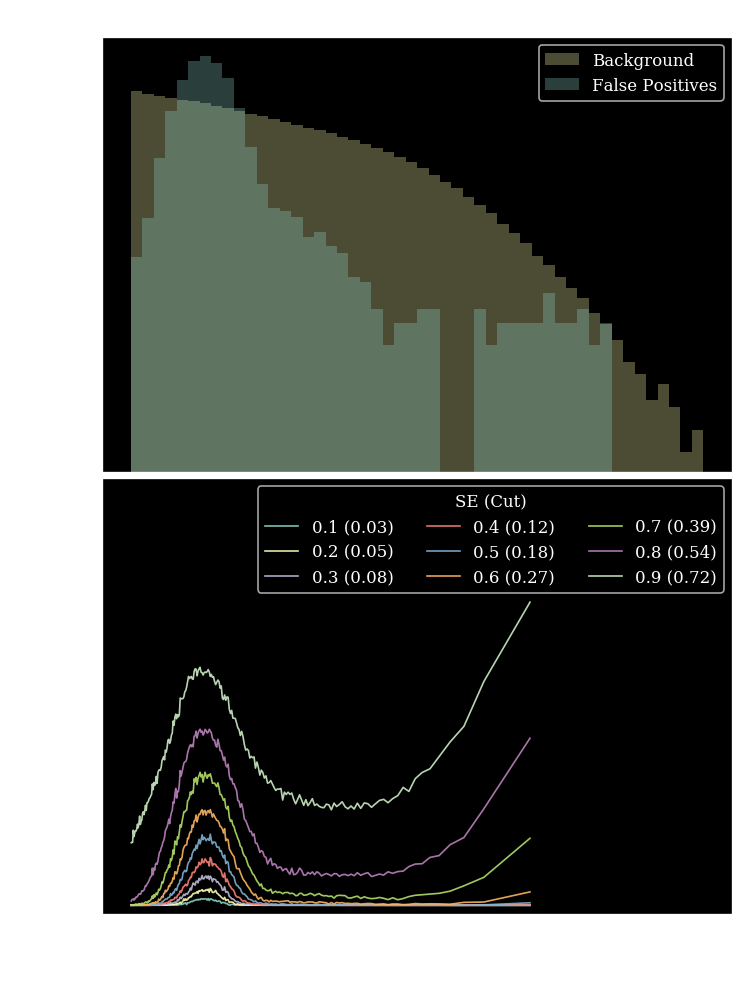

strength 20
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (260.0s)
 Train: loss:0.3123, acc:73% || Val: loss: 0.0690, acc:81%, R50: 16.1496, 1/JSD: 27.0905


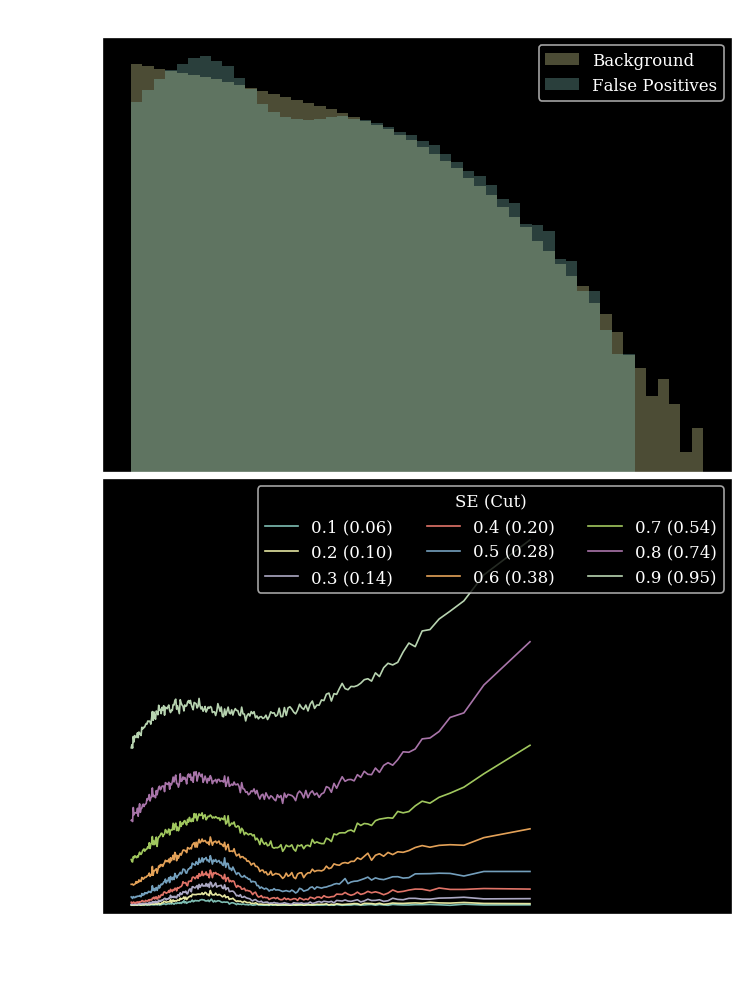

strength 20
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (282.7s)
 Train: loss:0.3132, acc:73% || Val: loss: 0.0687, acc:81%, R50: 15.4299, 1/JSD: 32.0596


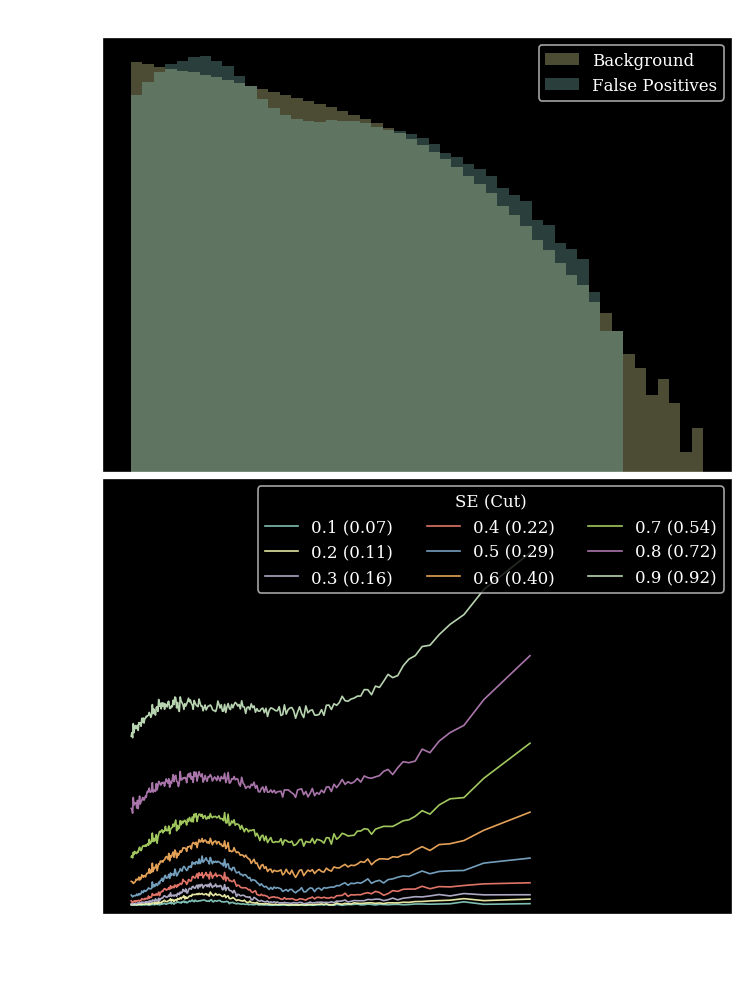

strength 20
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (294.8s)
 Train: loss:0.3379, acc:71% || Val: loss: 0.0697, acc:82%, R50: 16.1133, 1/JSD: 24.2022


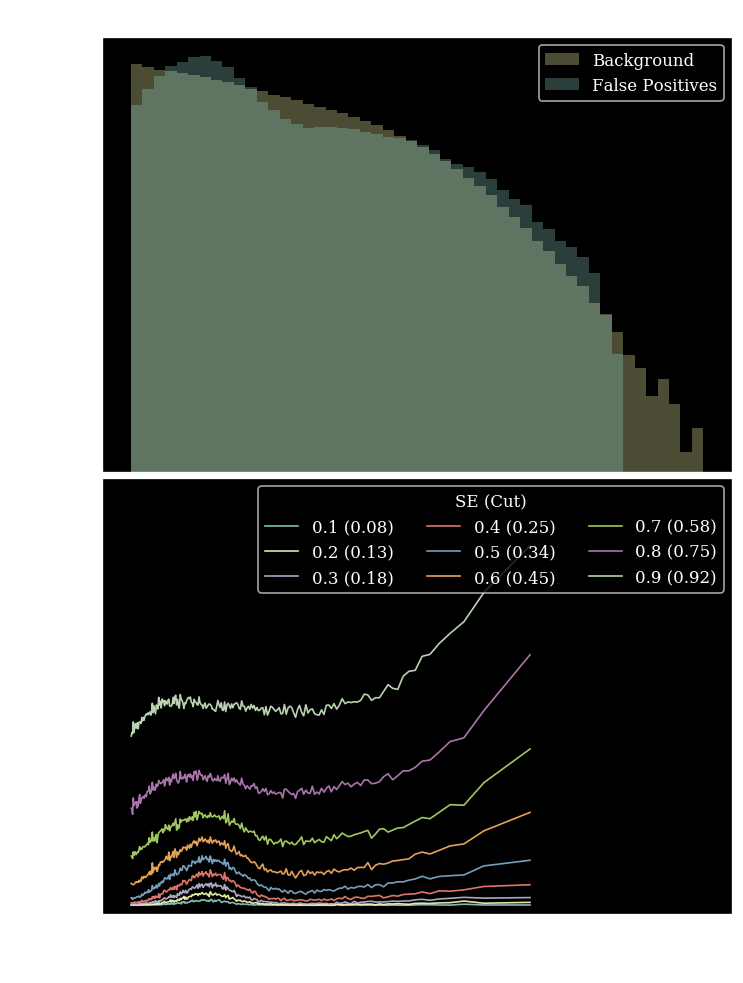

strength 20
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (262.4s)
 Train: loss:0.3835, acc:68% || Val: loss: 0.0739, acc:85%, R50: 17.4936, 1/JSD: 16.8127


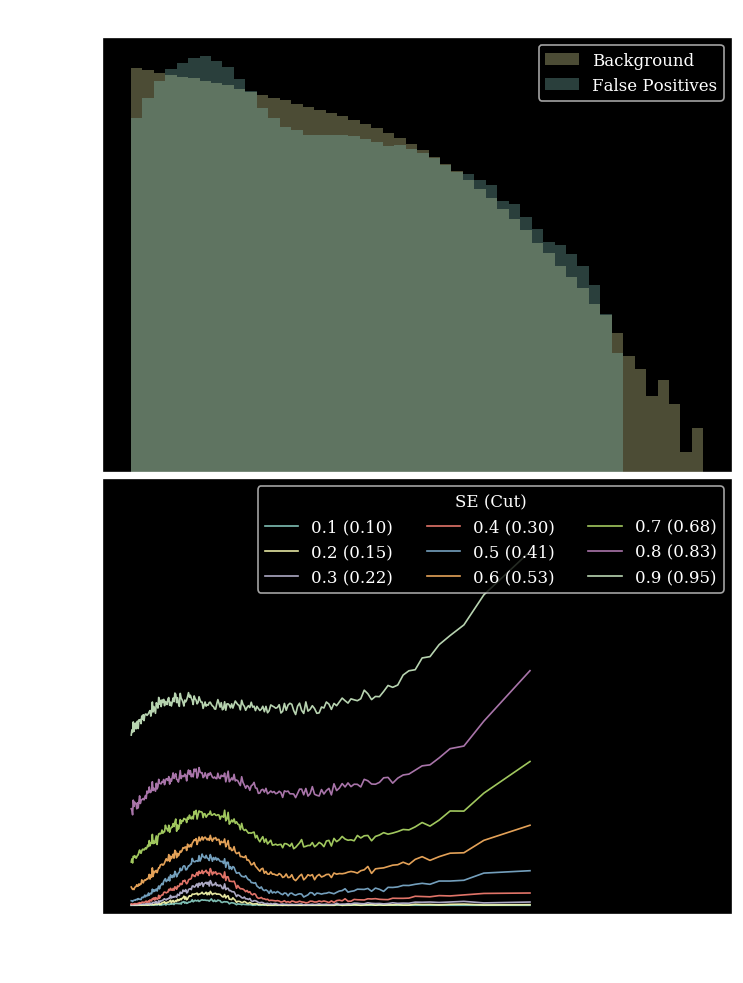

strength 45
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (276.8s)
 Train: loss:0.3593, acc:70% || Val: loss: 0.0774, acc:82%, R50: 13.7925, 1/JSD: 59.9422


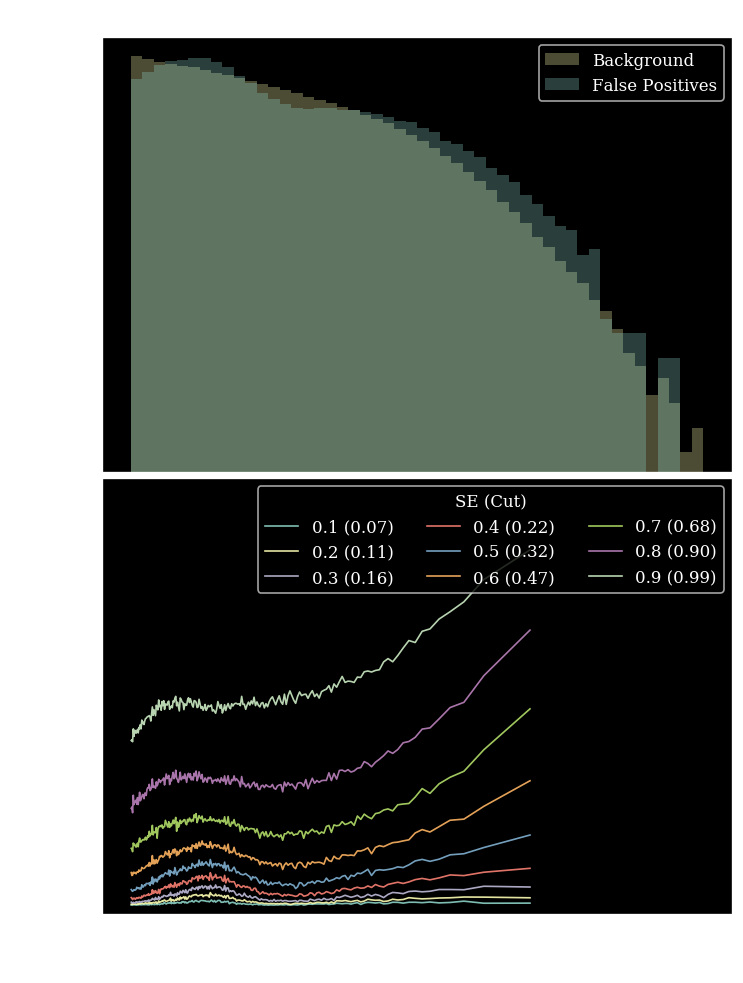

strength 45
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (296.6s)
 Train: loss:0.3664, acc:69% || Val: loss: 0.0779, acc:82%, R50: 13.1863, 1/JSD: 78.6835


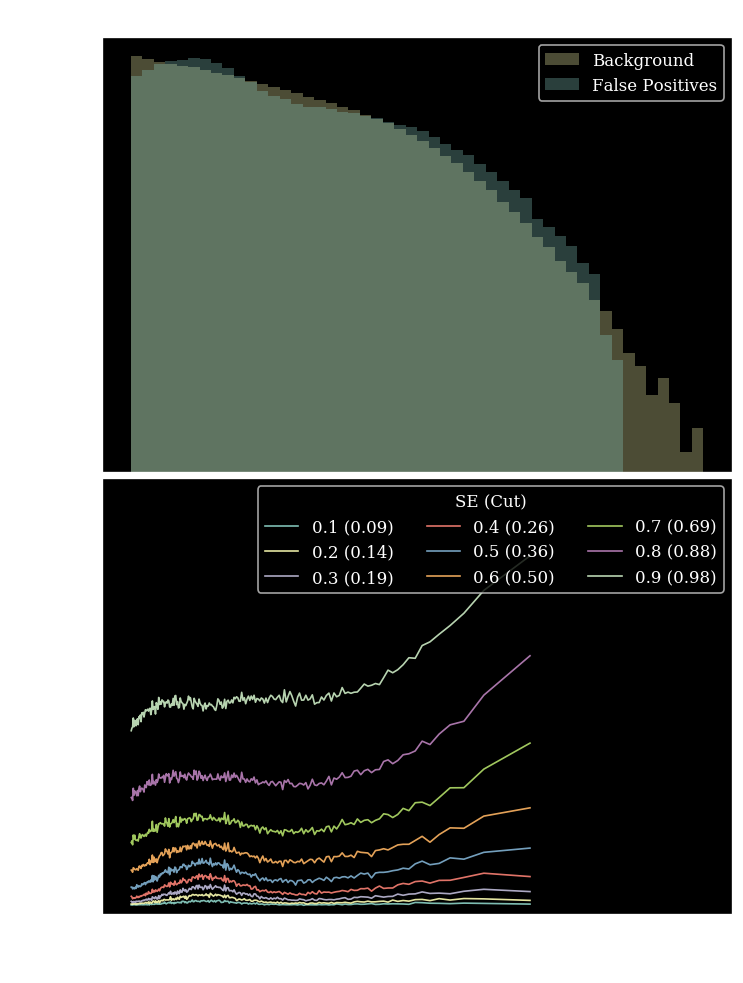

strength 45
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (263.3s)
 Train: loss:0.4151, acc:65% || Val: loss: 0.0840, acc:84%, R50: 14.0689, 1/JSD: 55.0336


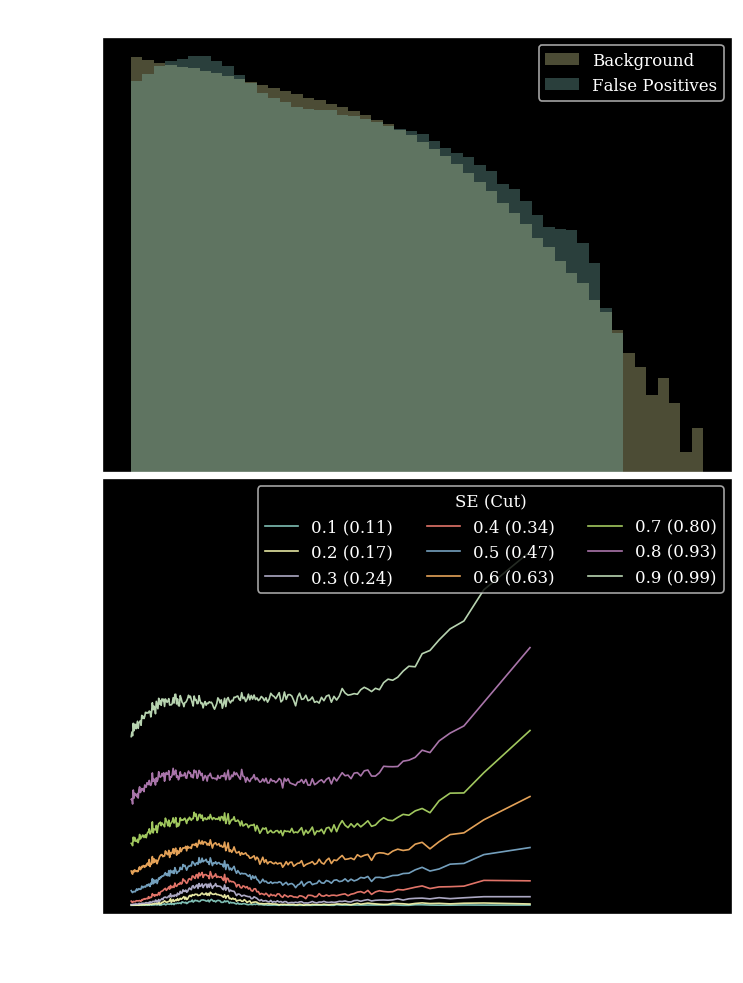

strength 45
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (278.4s)
 Train: loss:0.4671, acc:59% || Val: loss: 0.0993, acc:86%, R50: 16.5173, 1/JSD: 27.8817


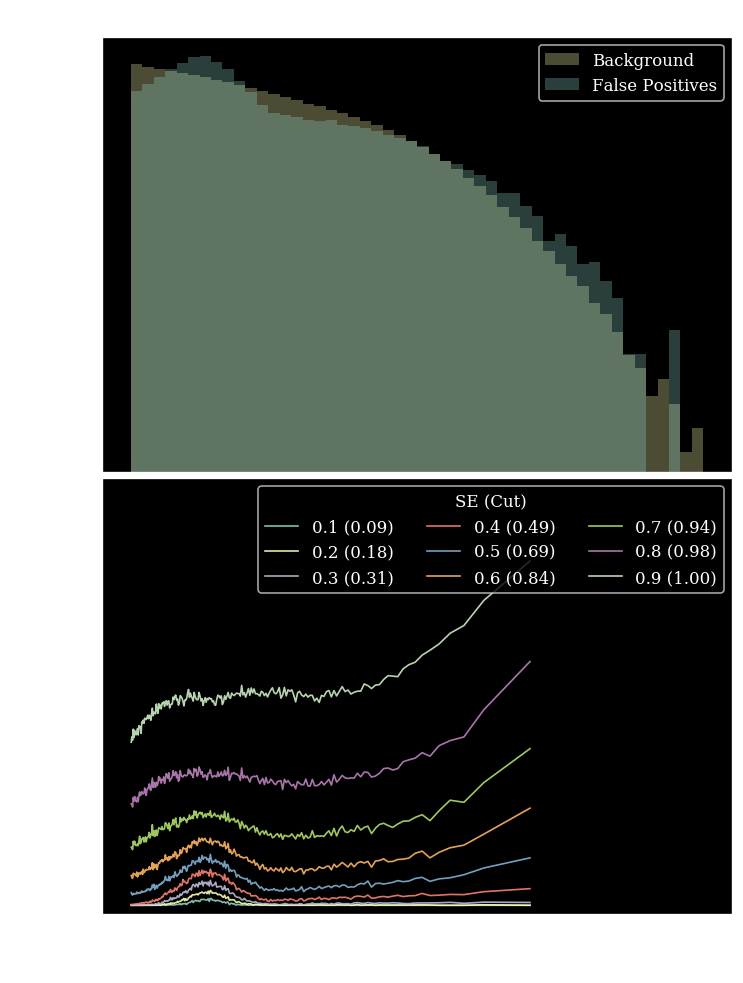

strength 75
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (292.6s)
 Train: loss:0.3913, acc:67% || Val: loss: 0.0851, acc:83%, R50: 12.7937, 1/JSD: 73.1737


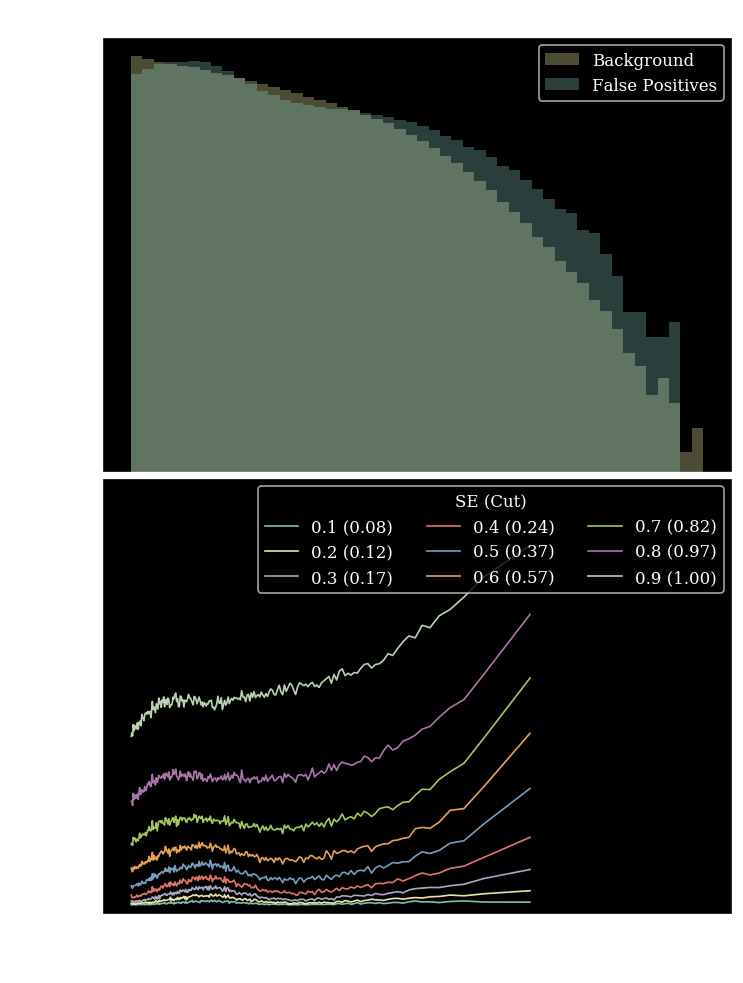

strength 75
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (267.1s)
 Train: loss:0.4068, acc:64% || Val: loss: 0.0882, acc:83%, R50: 12.0390, 1/JSD: 143.3736


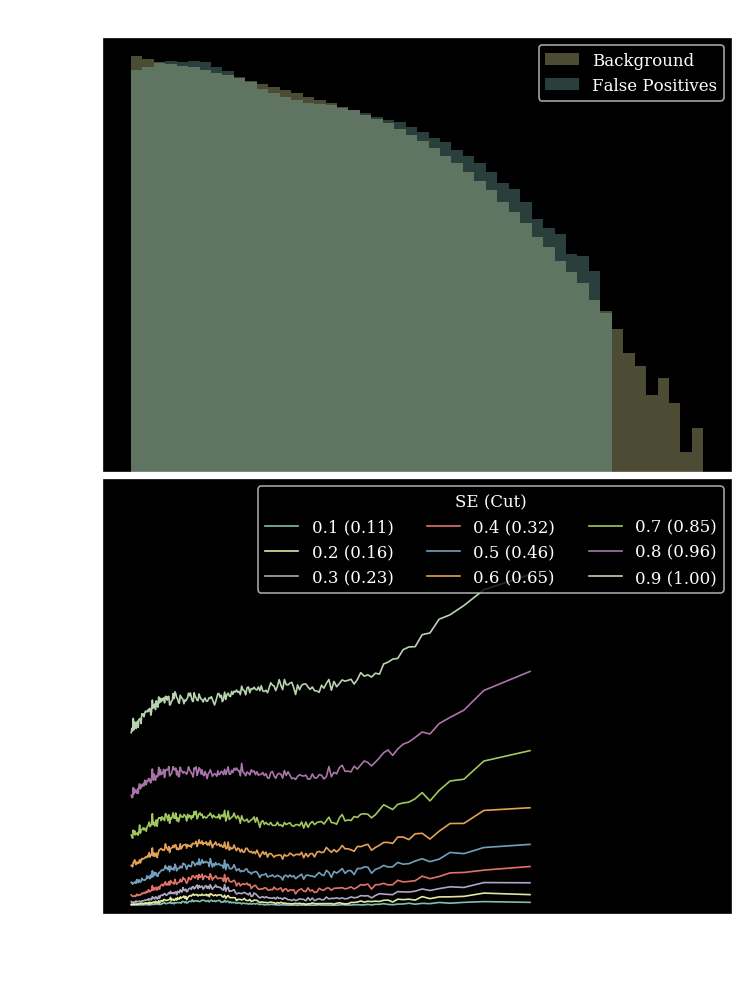

strength 75
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (280.7s)
 Train: loss:0.4720, acc:59% || Val: loss: 0.1011, acc:85%, R50: 13.0734, 1/JSD: 95.2148


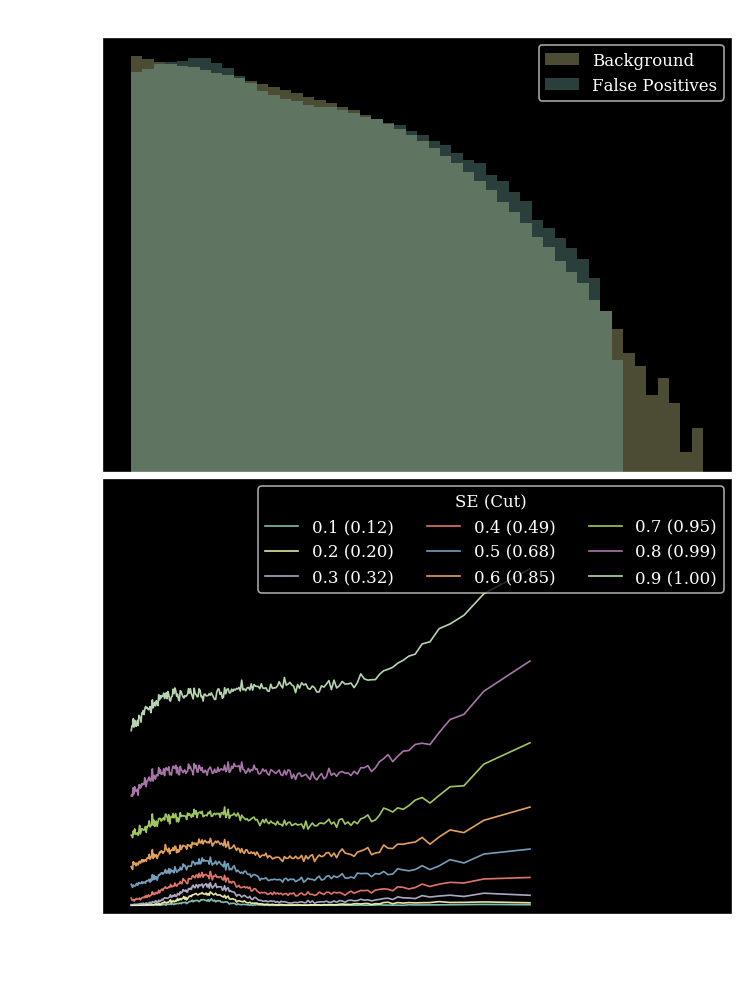

strength 75
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (293.9s)
 Train: loss:0.5254, acc:52% || Val: loss: 0.1218, acc:85%, R50: 15.8616, 1/JSD: 27.8510


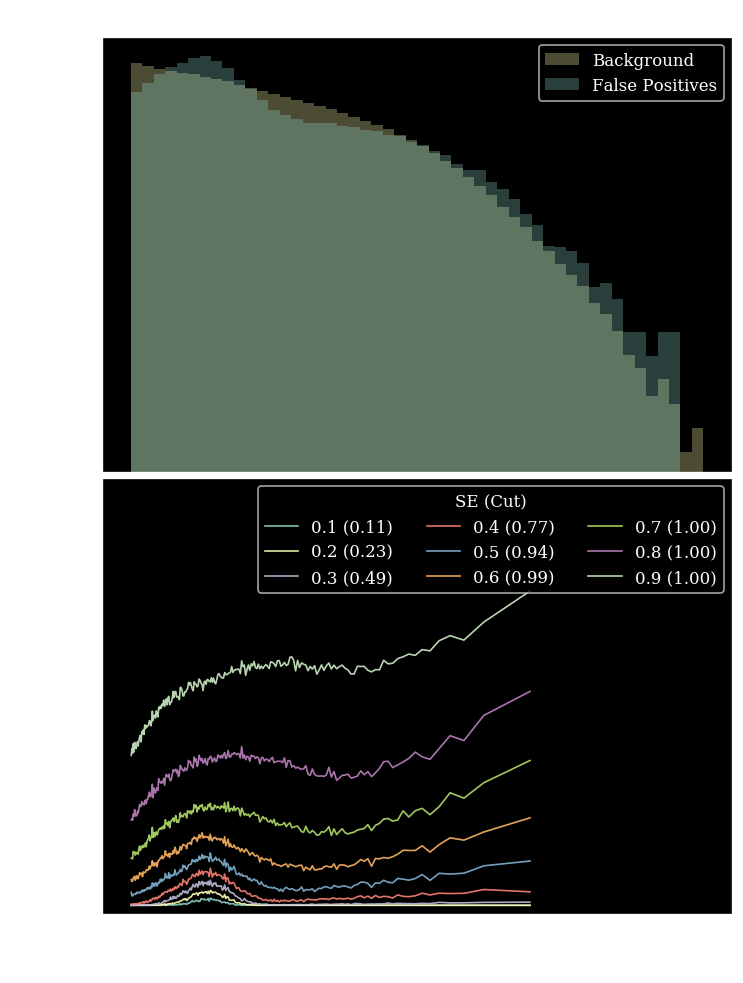

strength 100
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (261.1s)
 Train: loss:0.4191, acc:65% || Val: loss: 0.0905, acc:83%, R50: 12.0478, 1/JSD: 76.1215


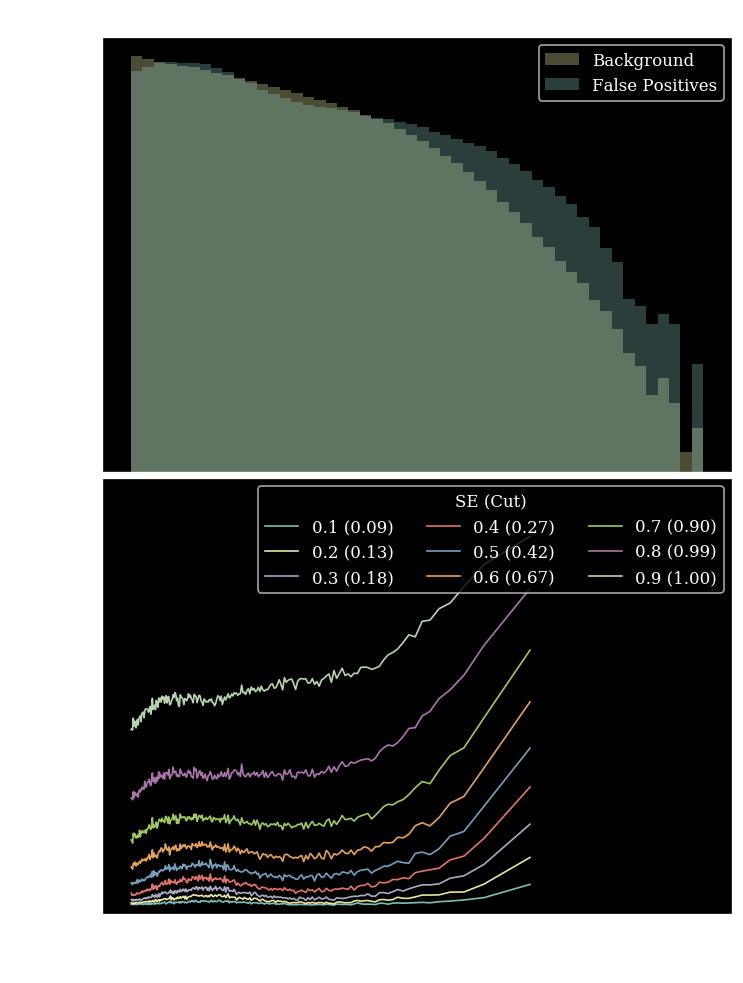

strength 100
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (282.5s)
 Train: loss:0.4280, acc:62% || Val: loss: 0.0957, acc:84%, R50: 11.5969, 1/JSD: 175.8774


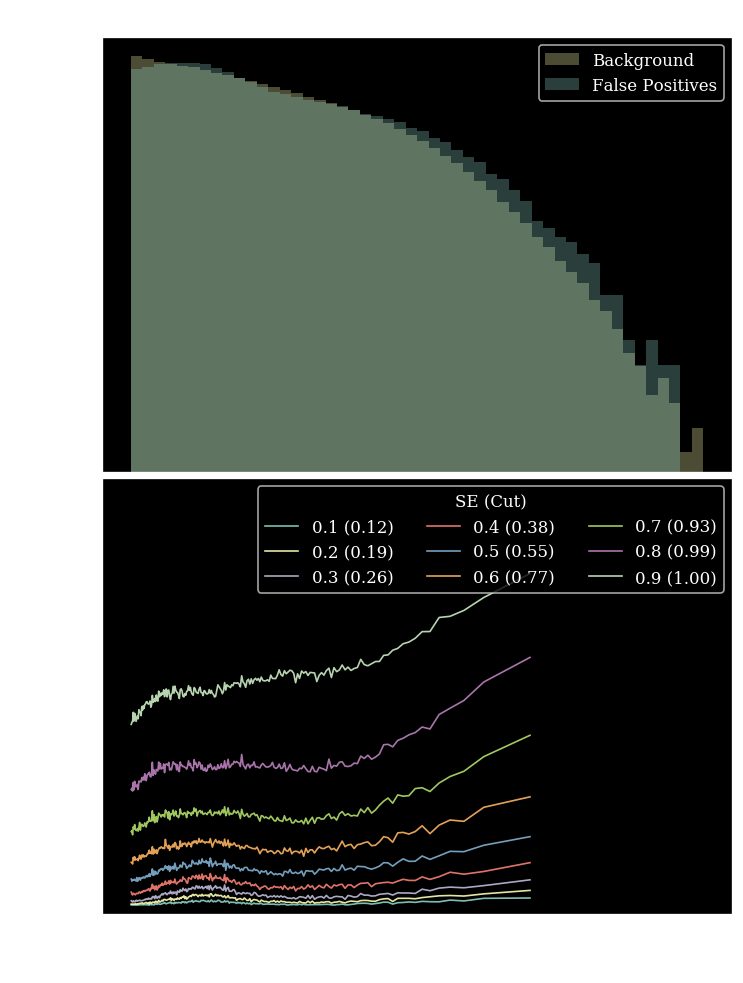

strength 100
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (294.8s)
 Train: loss:0.5036, acc:55% || Val: loss: 0.1114, acc:85%, R50: 12.5897, 1/JSD: 112.0723


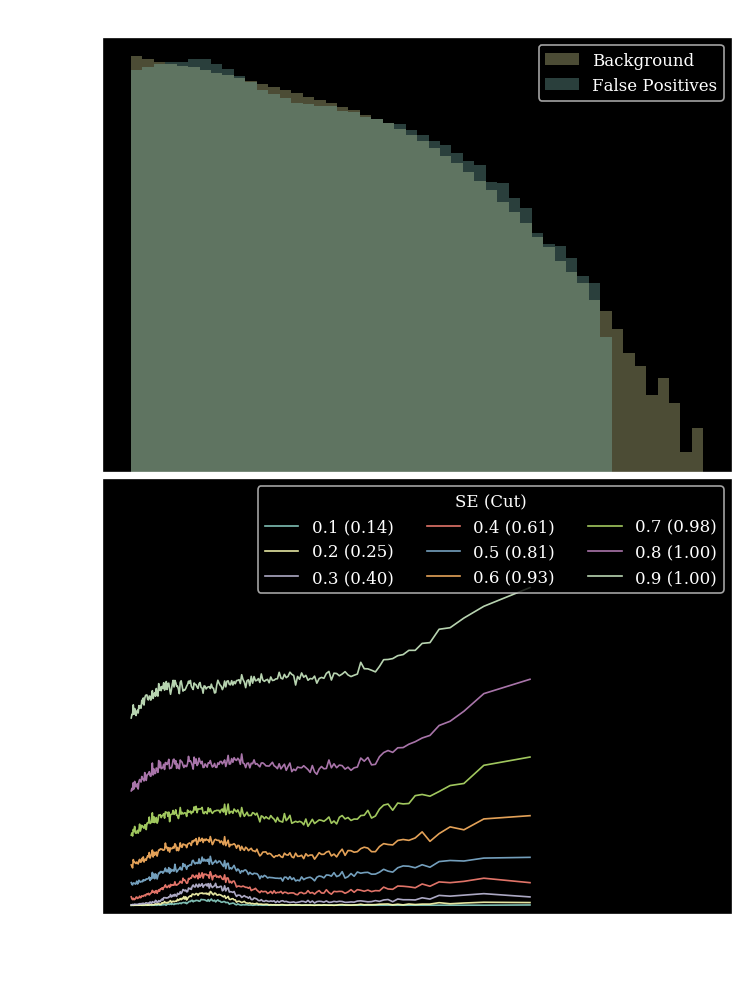

strength 100
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (263.4s)
 Train: loss:0.5473, acc:49% || Val: loss: 0.1333, acc:85%, R50: 16.2842, 1/JSD: 20.1161


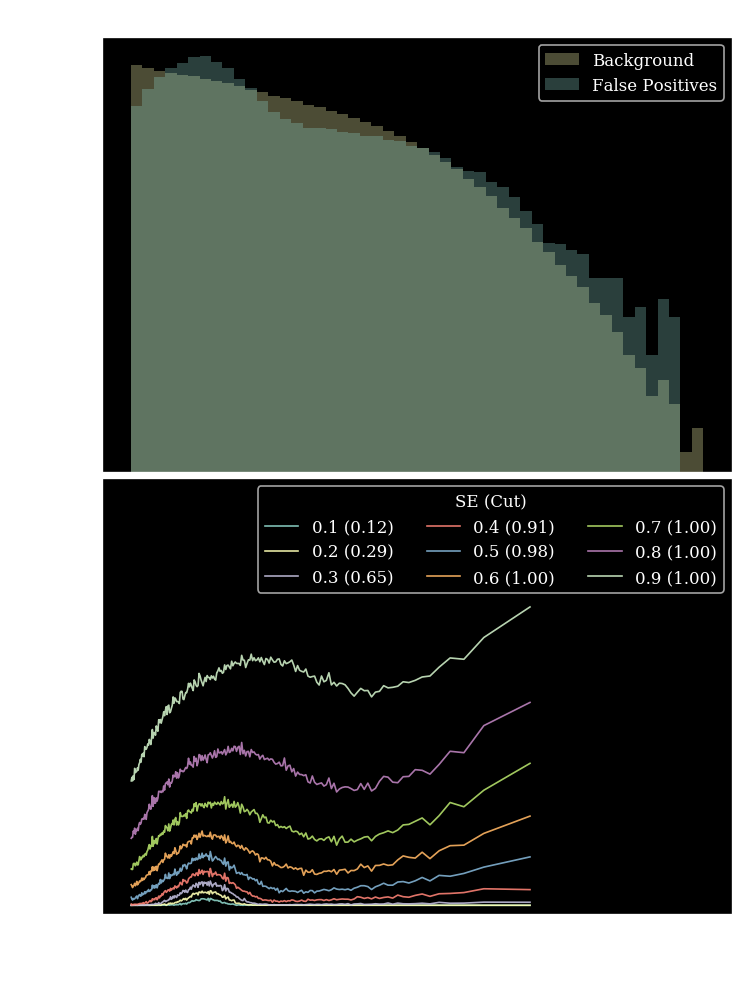

strength 125
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (276.6s)
 Train: loss:0.4402, acc:64% || Val: loss: 0.0955, acc:83%, R50: 11.6017, 1/JSD: 84.2586


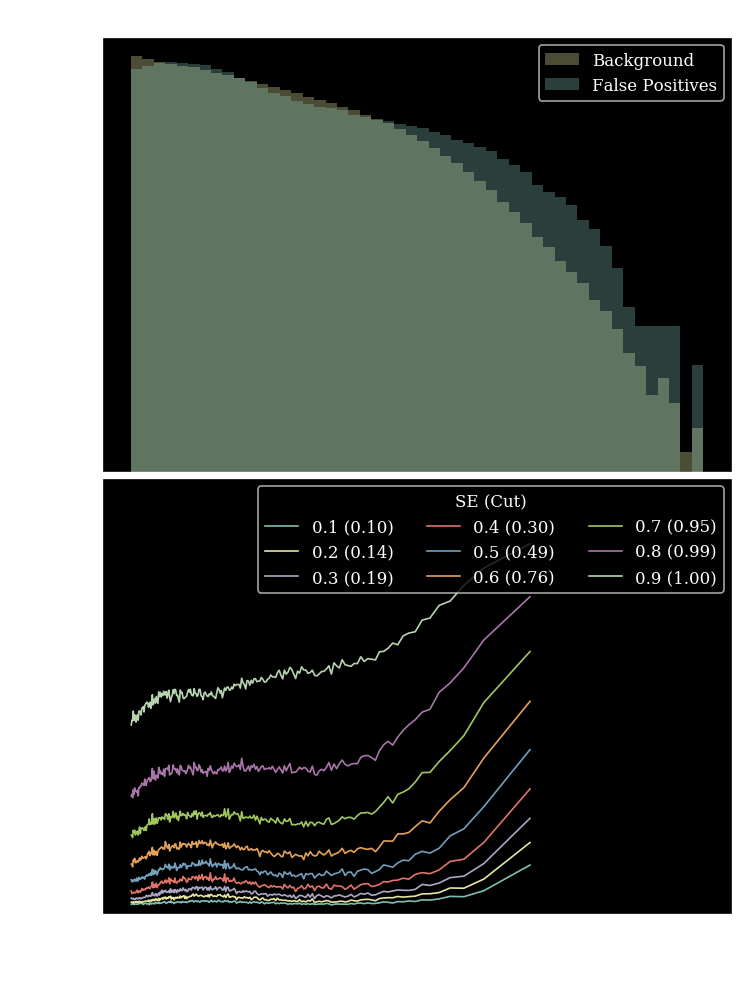

strength 125
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (298.6s)
 Train: loss:0.4422, acc:60% || Val: loss: 0.1022, acc:84%, R50: 11.2540, 1/JSD: 215.2938


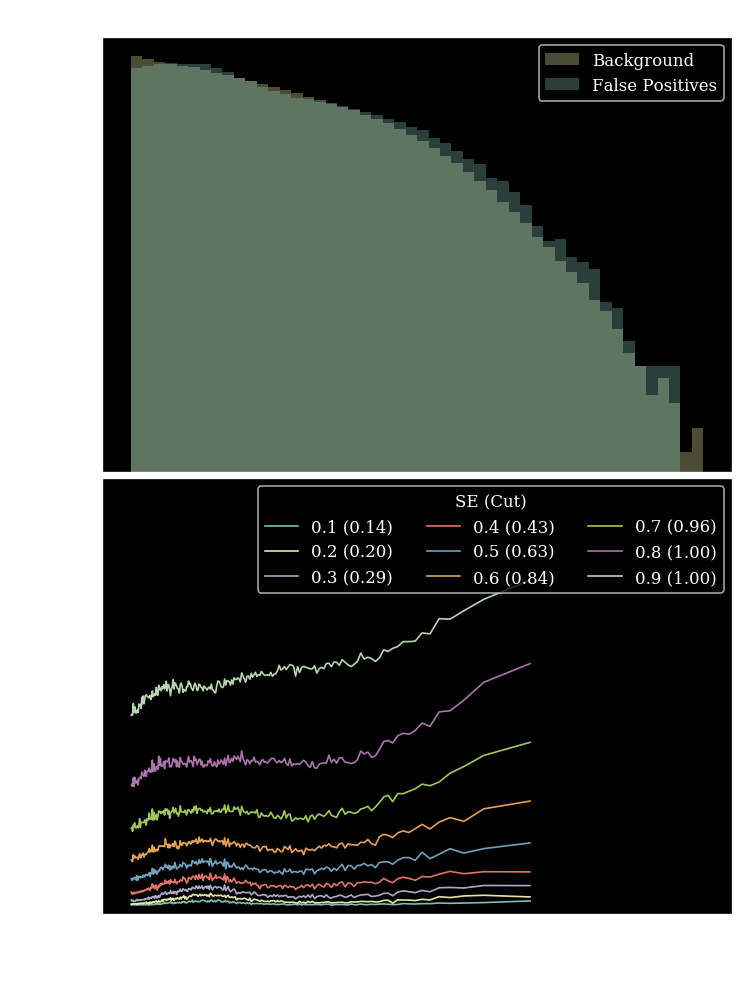

strength 125
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (264.6s)
 Train: loss:0.5248, acc:52% || Val: loss: 0.1213, acc:85%, R50: 12.2494, 1/JSD: 129.9938


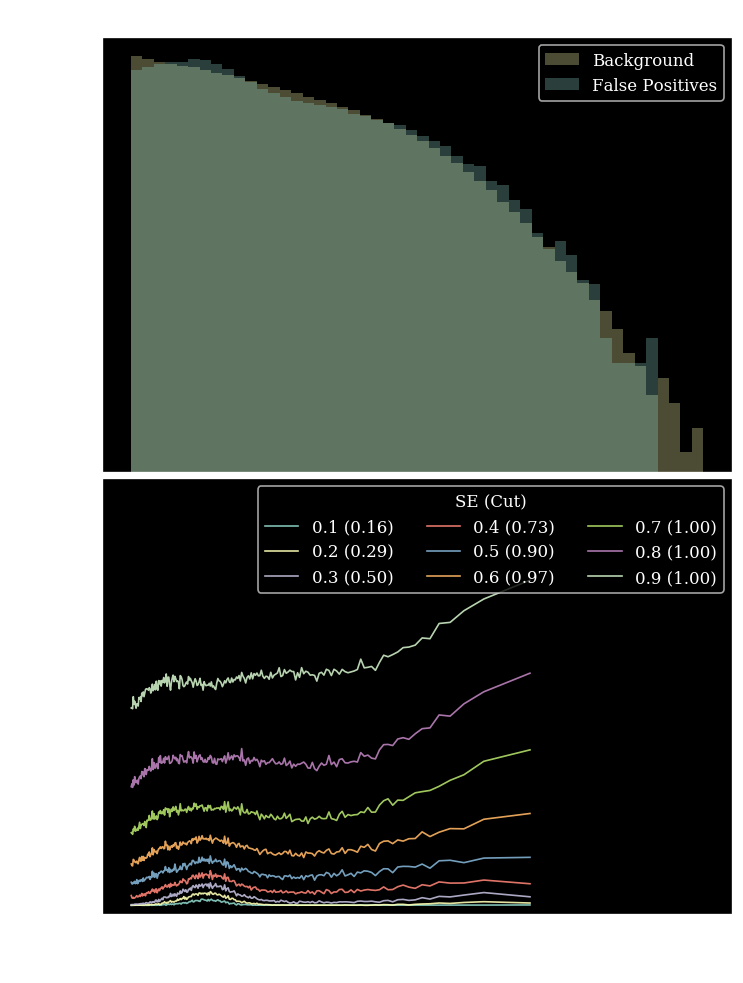

strength 125
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (280.9s)
 Train: loss:0.5623, acc:46% || Val: loss: 0.1438, acc:84%, R50: 15.6717, 1/JSD: 16.0954


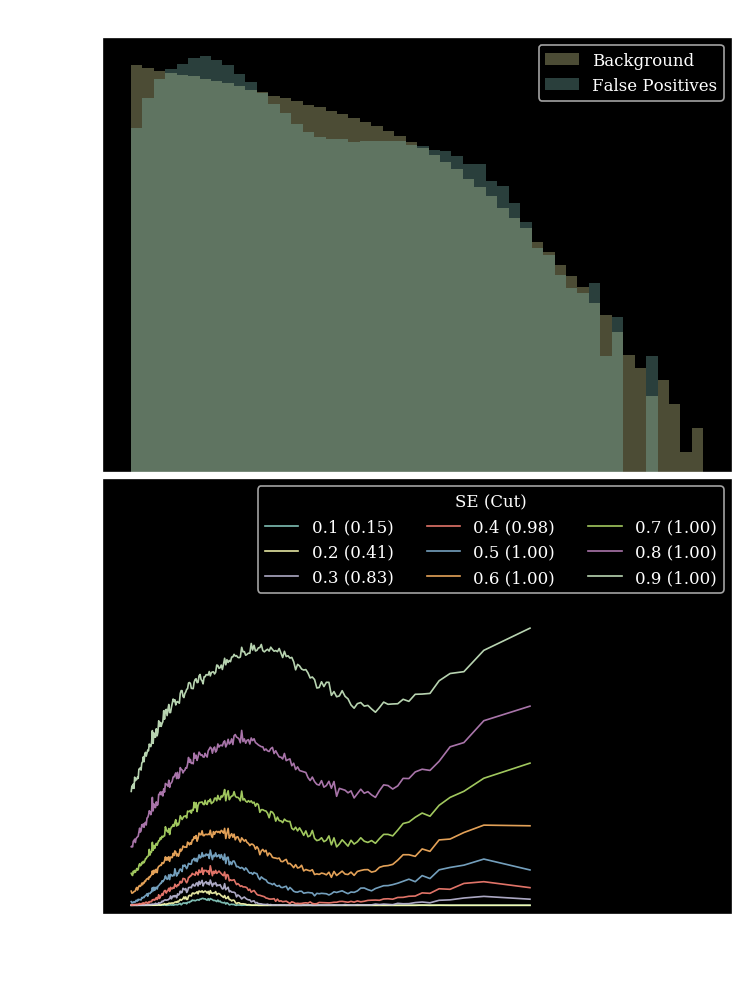

strength 200
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (309.1s)
 Train: loss:0.4790, acc:60% || Val: loss: 0.1081, acc:83%, R50: 10.3254, 1/JSD: 215.2624


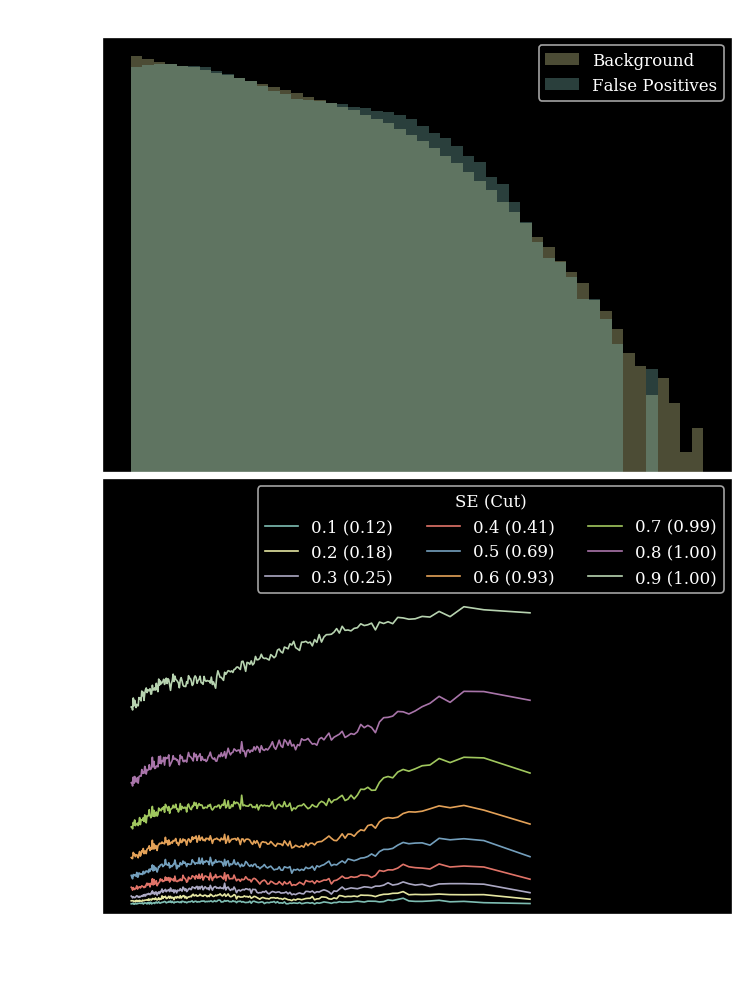

strength 200
Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625


In [ ]:
jsdR50flatstr0 = []
for i,frac in enumerate([1,20,45,75,100,125,200,500,1000,1500]):
    for bins in [5,20,50,100]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=False,order=0)
        log=Logger(f"./logs/new/8192/Flat(f{frac}b{bins}).txt")
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        torch.save(model_L.state_dict(),f"./logs/new/8192/Flat(f{frac}b{bins}).pt")
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}, bins:{bins}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/8192/Flat(f{frac}b{bins}).png")
        jsdR50flatstr0.append(out)

# DisCo str

strength 1
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (559.6s)
 Train: loss:0.2134, acc:79% || Val: loss: 0.0561, acc:80%, R50: 24.4047, 1/JSD: 4.0426


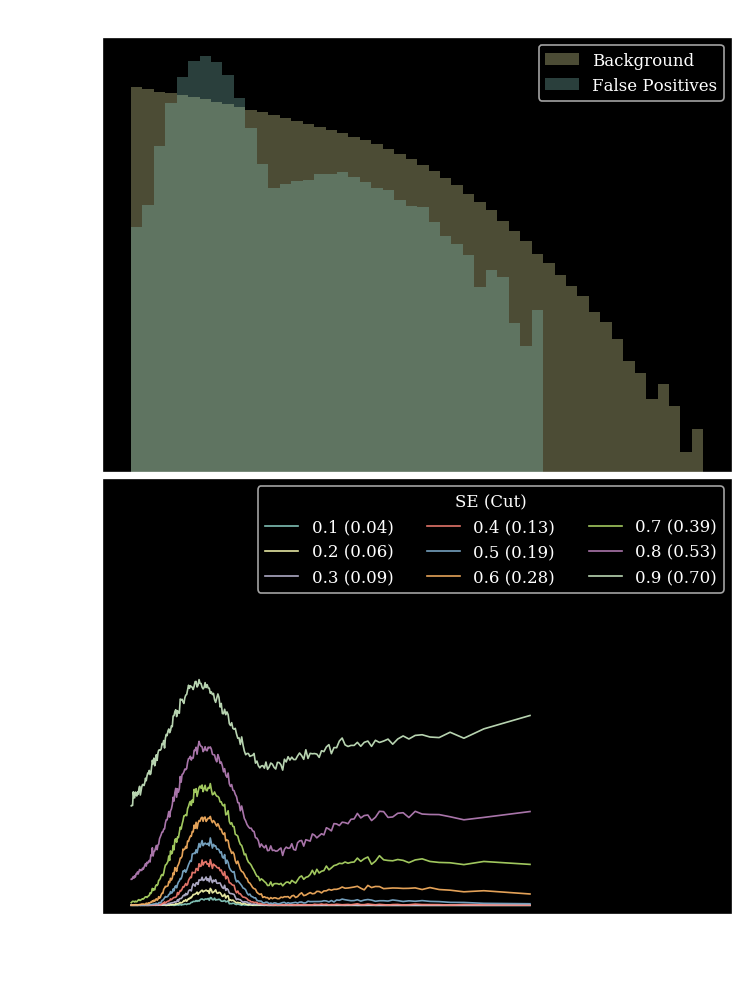

strength 5
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (561.3s)
 Train: loss:0.2397, acc:76% || Val: loss: 0.0625, acc:76%, R50: 15.8983, 1/JSD: 23.9364


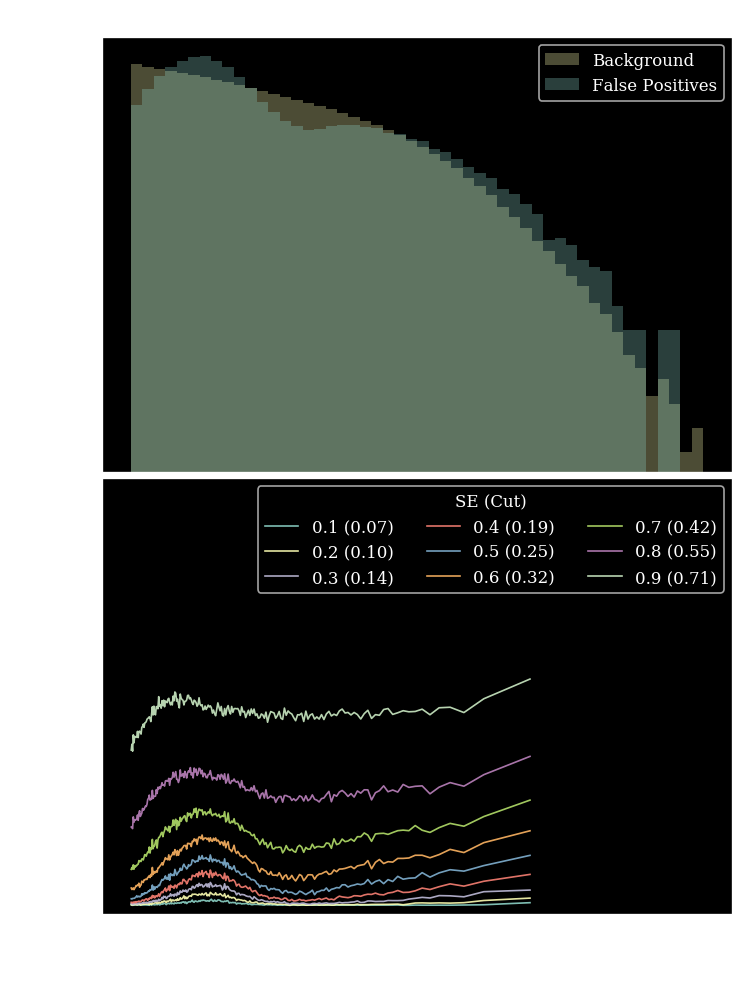

strength 10
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (561.8s)
 Train: loss:0.2587, acc:75% || Val: loss: 0.0664, acc:75%, R50: 11.5924, 1/JSD: 161.0491


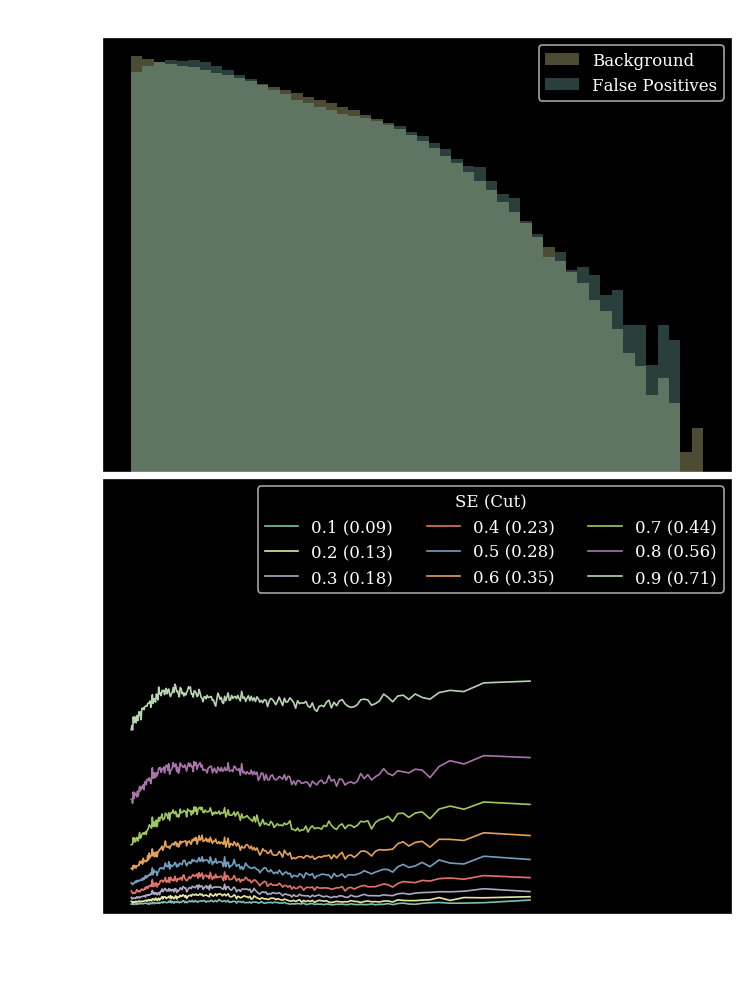

strength 20
Entering Training...
Epoch:0001/0200  (7.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (561.3s)
 Train: loss:0.2830, acc:71% || Val: loss: 0.0718, acc:74%, R50: 9.2336, 1/JSD: 694.3534


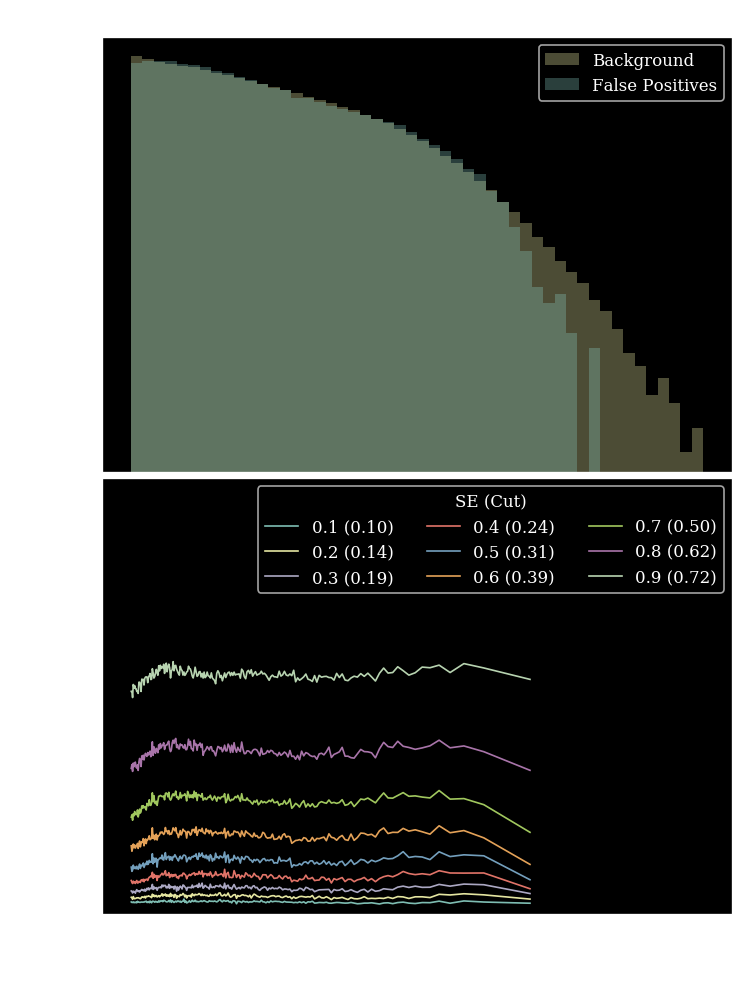

strength 30
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (564.6s)
 Train: loss:0.3037, acc:69% || Val: loss: 0.0742, acc:75%, R50: 8.5725, 1/JSD: 969.3285


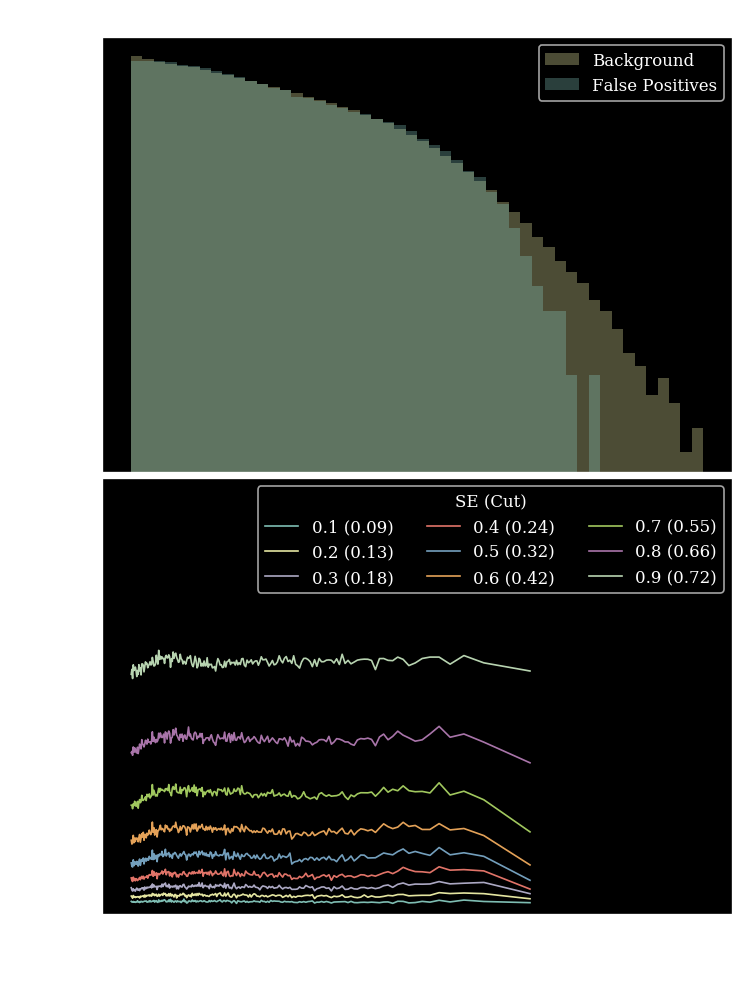

strength 50
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (562.3s)
 Train: loss:0.3235, acc:69% || Val: loss: 0.0760, acc:74%, R50: 8.2251, 1/JSD: 1040.0825


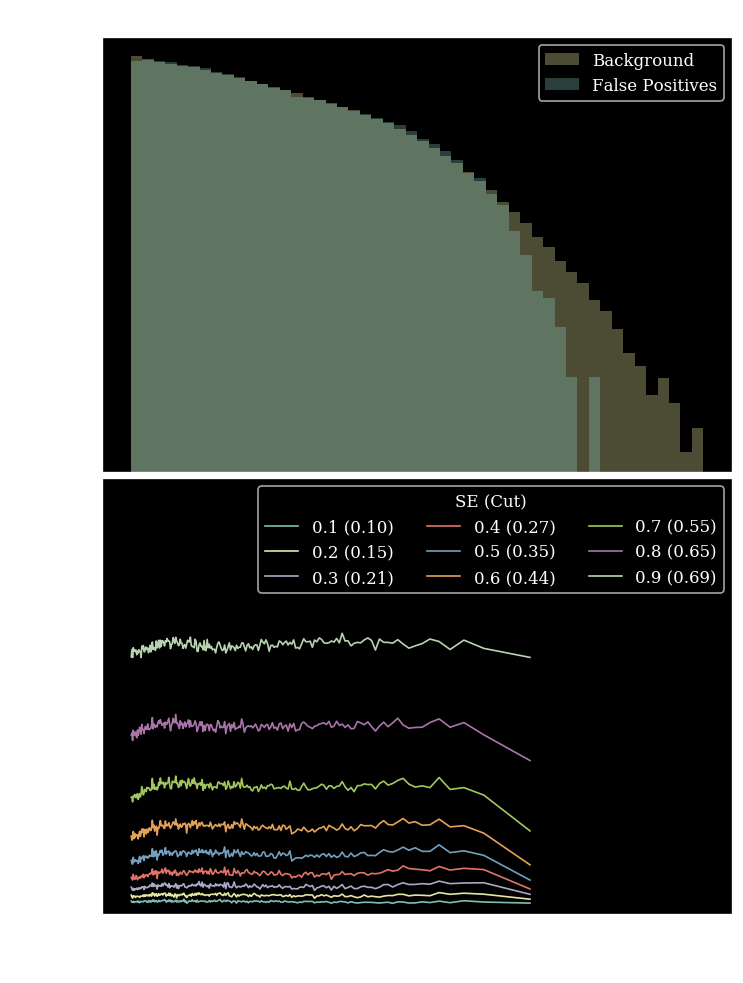

strength 100
Entering Training...
Epoch:0001/0200  (7.2  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (560.0s)
 Train: loss:0.3529, acc:64% || Val: loss: 0.0848, acc:71%, R50: 5.3721, 1/JSD: 1789.3773


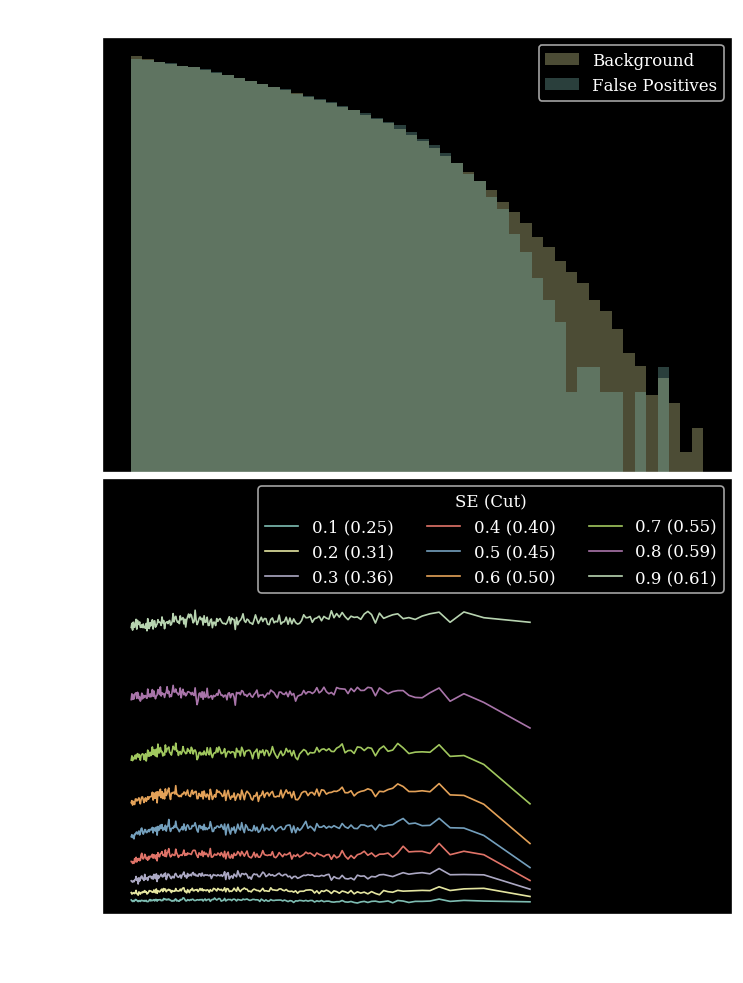

strength 150
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (559.3s)
 Train: loss:0.4018, acc:58% || Val: loss: 0.0908, acc:68%, R50: 3.6556, 1/JSD: 3008.3210


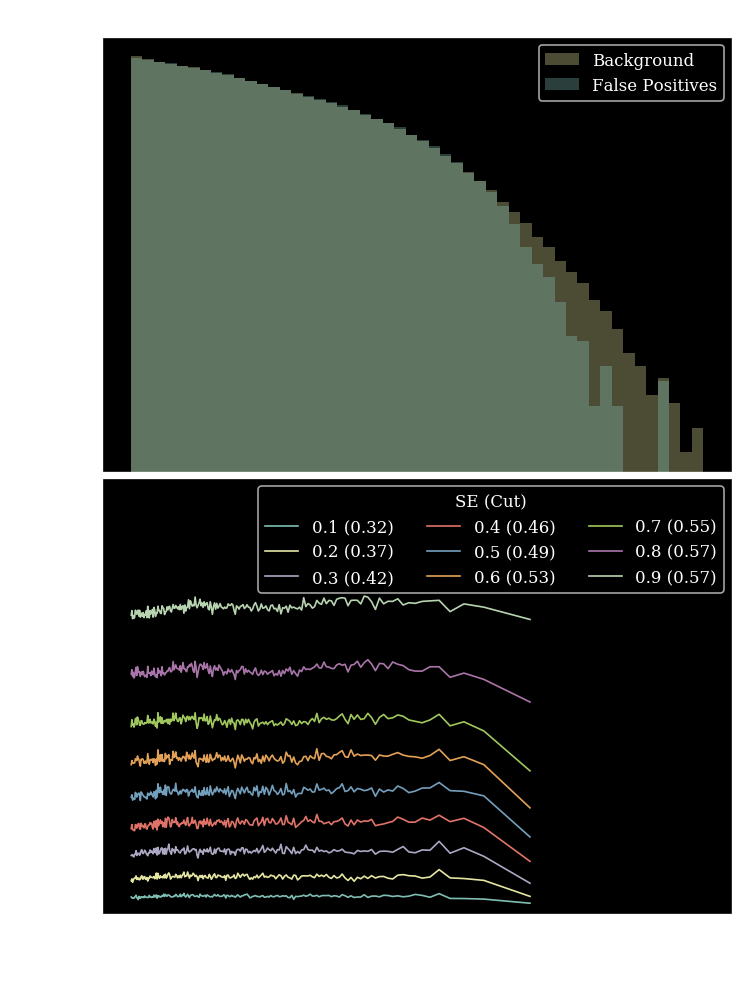

strength 200
Entering Training...
Epoch:0001/0200  (7.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (558.5s)
 Train: loss:0.4361, acc:54% || Val: loss: 0.0933, acc:65%, R50: 3.0976, 1/JSD: 5511.8709


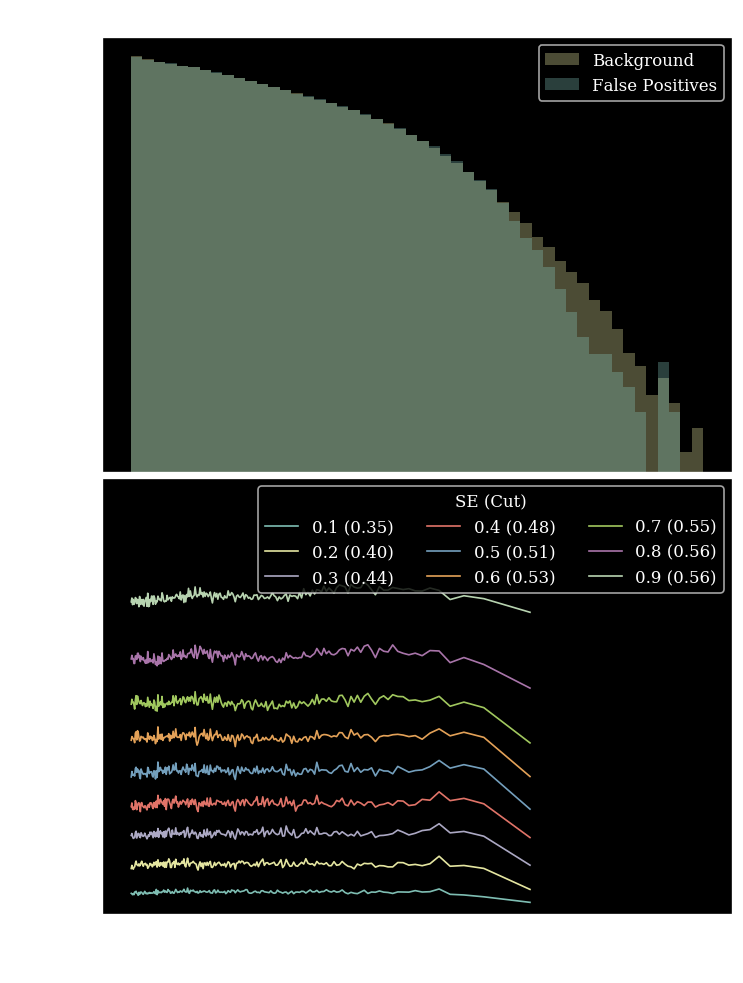

strength 1000
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.8180, 1/JSD: 91.3625
Epoch:0200/0200  (560.9s)
 Train: loss:1.1730, acc:50% || Val: loss: 0.0968, acc:60%, R50: 2.4494, 1/JSD: 9160.3361


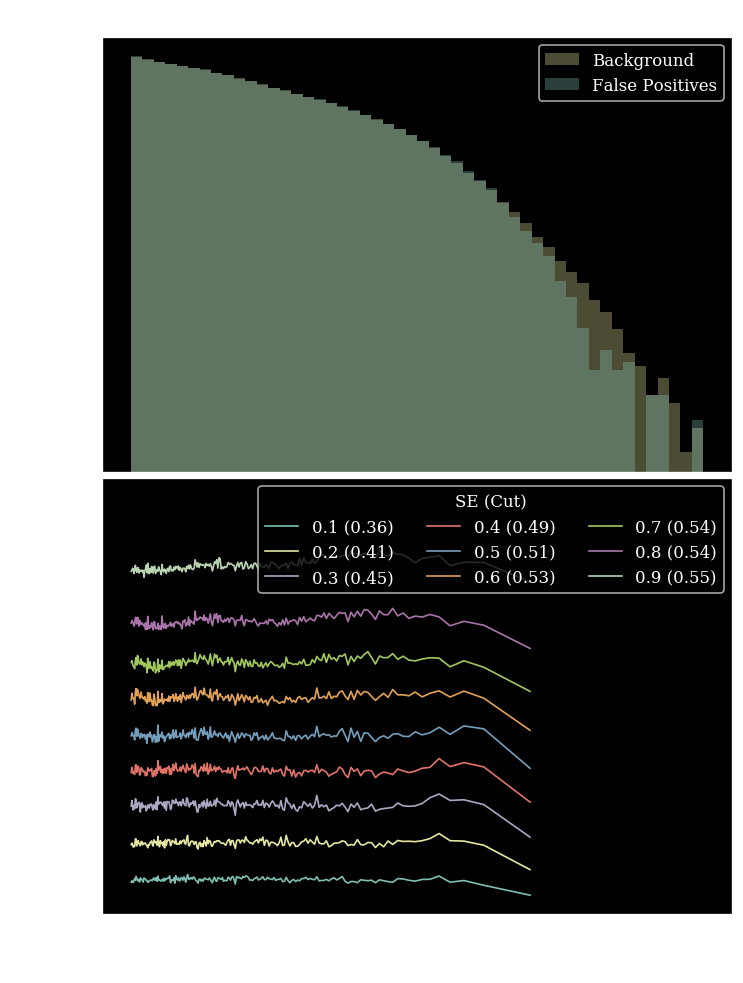

In [18]:
jsdR50Disco = []
for i,frac in enumerate([1,5,10,20,30,50,100,150,200,1000]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger(f"./logs/new/8192(1)/DisCo(f{frac}).txt")
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              metrics=[metrics_train_L,metrics_val_L])
    torch.save(model_L.state_dict(),f"./logs/new/8192(1)/DisCo(f{frac}).pt")
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
               y=test_labels,x_biased=test[:,0],mbins=200,histbins=50,
                       f=f"./logs/new/8192(1)/DisCo(f{frac}).png")

    jsdR50Disco.append(out)

Text(0.5, 1.0, '8192(1) batch size')

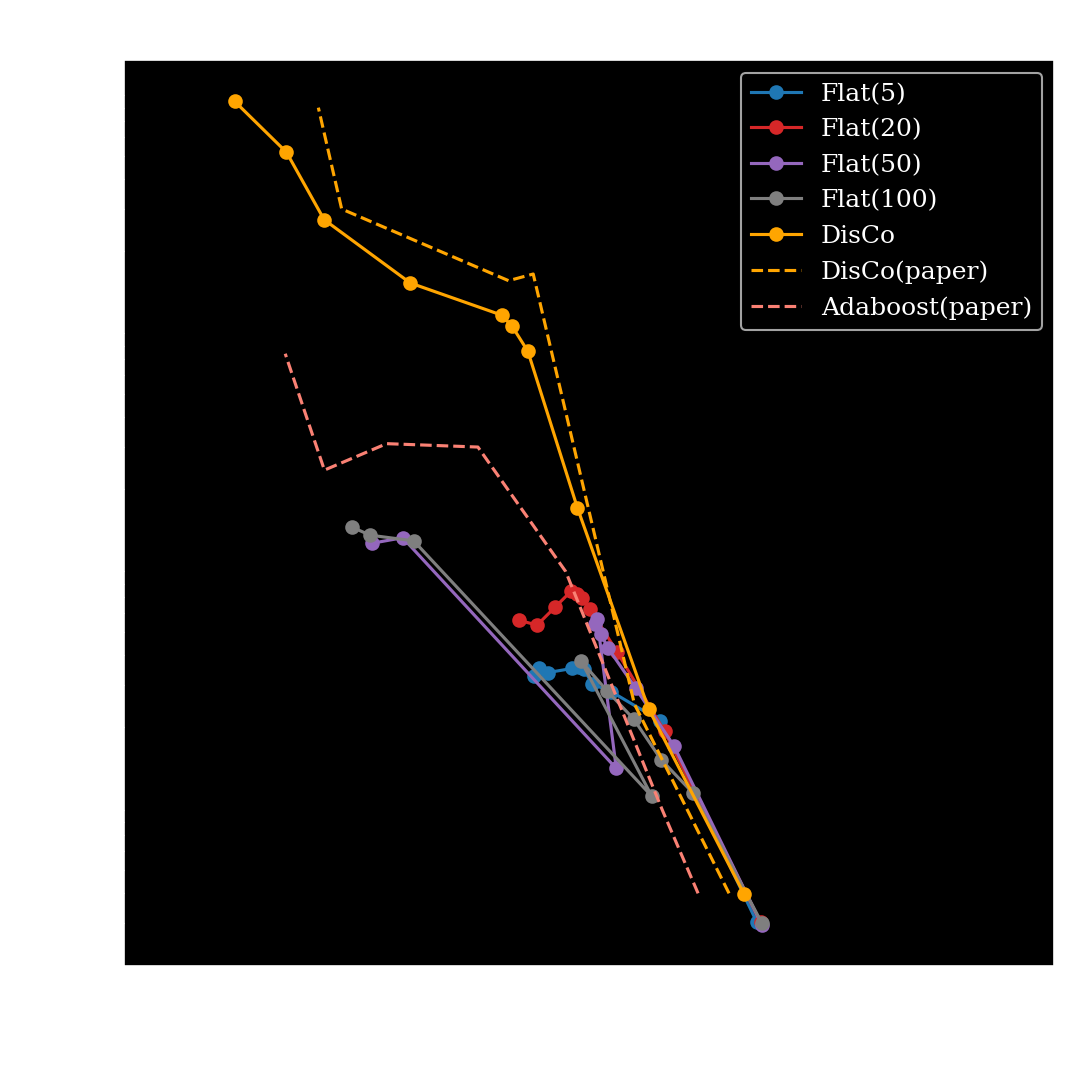

In [19]:
JSD,R50 = zip(*jsdR50flatstr[0::4])
JSDa,R50a = zip(*jsdR50flatstr[1::4])
JSDb,R50b = zip(*jsdR50flatstr[2::4])
JSDc,R50c = zip(*jsdR50flatstr[3::4])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat(5)',c='tab:blue')
plt.errorbar(R50a,JSDa,fmt='-o',label='Flat(20)',c='tab:red')
plt.errorbar(R50b,JSDb,fmt='-o',label='Flat(50)',c='tab:purple')
plt.errorbar(R50c,JSDc,fmt='-o',label='Flat(100)',c='tab:gray')
plt.errorbar(R502,np.array(JSD2),fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('R50',fontsize=20)
plt.ylabel('1/JSD',fontsize=20)
plt.title("8192(1) batch size",fontsize=20)
#fig.savefig(f"./logs/new/8192(1)/PhaseSpace.png")